# Movie plot processing
We're reading a dataset containing movie popularities and keywords (`movies_metadata.csv` and `keywords.csv` downloaded from https://www.kaggle.com/rounakbanik/the-movies-dataset). In the end, we want to have the titles, summaries and keyword embeddings for some well-known movies.

In [1]:
import pandas as pd
import numpy as np
import json
import spacy
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
metadata = pd.read_csv('movies_metadata.csv', index_col='id', low_memory=False)
print(f'metadata count: {len(metadata)}')

metadata count: 45466


It turns out that some of the ids don't get parsed well - le'ts just discard them.

In [3]:
def isdigit(s):
    return s.isdigit()

metadata = metadata.loc[metadata.index.map(isdigit)]
metadata.index = metadata.index.map(int)
print(f'metadata count after cleaning: {len(metadata)}')

metadata count after cleaning: 45463


In [4]:
keywords = pd.read_csv('keywords.csv', index_col='id')
print(f'keywords count: {len(metadata)}')

keywords count: 45463


We only need to process well-known movies, so that people know what they are about given their title. After some experiments, popularity proved to be a poor measure of how well-known a movie is, with the total number of votes it has received (be it positive or negative ones) being much better an indicator.

In [5]:
well_known = metadata.nlargest(256, 'vote_count')
joined = well_known.join(keywords)

It turns out that a few movies are duplicated in the keywords csv - but we can't remove them there, because that can cause a key error in the join.

In [6]:
joined.drop_duplicates(inplace=True) # zootopia is duplicated in the keywords
print(f'number of movies in joined table: {len(joined)}')

number of movies in joined table: 256


In [7]:
joined.head()

,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords
id,,,,,,,,,,,,,,,,,,,,,
11,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",11000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.starwars.com/films/star-wars-episod...,tt0076759,en,Star Wars,Princess Leia is captured and held hostage by ...,42.149697,...,775398007.0,121.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"A long time ago in a galaxy far, far away...",Star Wars,False,8.1,6778.0,"[{'id': 803, 'name': 'android'}, {'id': 4270, ..."
12,False,"{'id': 137697, 'name': 'Finding Nemo Collectio...",94000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://movies.disney.com/finding-nemo,tt0266543,en,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",25.497794,...,940335536.0,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,There are 3.7 trillion fish in the ocean. They...,Finding Nemo,False,7.6,6292.0,"[{'id': 494, 'name': 'father son relationship'..."
13,False,NaN,55000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0109830,en,Forrest Gump,A man with a low IQ has accomplished great thi...,48.307194,...,677945399.0,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The world will never be the same, once you've ...",Forrest Gump,False,8.2,8147.0,"[{'id': 422, 'name': 'vietnam veteran'}, {'id'..."
14,False,NaN,15000000,"[{'id': 18, 'name': 'Drama'}]",http://www.dreamworks.com/ab/,tt0169547,en,American Beauty,"Lester Burnham, a depressed suburban father in...",20.726578,...,356296601.0,122.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Look closer.,American Beauty,False,7.9,3438.0,"[{'id': 255, 'name': 'male nudity'}, {'id': 29..."
18,False,NaN,90000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0119116,en,The Fifth Element,"In 2257, a taxi driver is unintentionally give...",24.30526,...,263920180.0,126.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,There is no future without it.,The Fifth Element,False,7.3,3962.0,"[{'id': 402, 'name': 'clone'}, {'id': 444, 'na..."


In [8]:
selected = pd.DataFrame()
selected['title'] = joined['title']

In [9]:
def extract_keywords(keywords_str):
    keywords_list = eval(keywords_str) # keywords_str looks a bit like json, but it's actually python syntax
    return ' '.join(keyword['name'] for keyword in keywords_list)

selected['keywords'] = joined['keywords'].map(extract_keywords)

In [10]:
selected.head()

,title,keywords
id,,
11,Star Wars,android galaxy hermit death star lightsaber je...
12,Finding Nemo,father son relationship harbor underwater fish...
13,Forrest Gump,vietnam veteran hippie mentally disabled runni...
14,American Beauty,male nudity female nudity adultery parent chil...
18,The Fifth Element,clone taxi cyborg egypt future stowaway space ...


## It's NLP time!

In [11]:
nlp = spacy.load('en_core_web_lg')

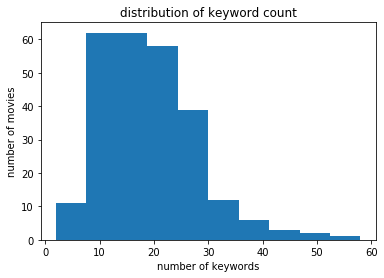

In [12]:
plt.title('distribution of keyword count')
plt.hist(selected['keywords'].map(nlp).map(len))
plt.xlabel('number of keywords')
plt.ylabel('number of movies')
plt.show()

In [13]:
keyword_vectors = [nlp(keywords).vector for keywords in selected['keywords']]

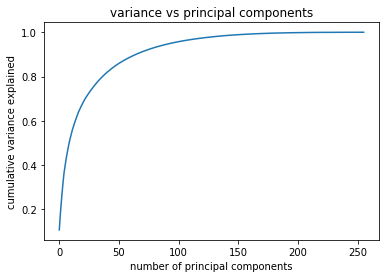

In [14]:
pca = PCA().fit(keyword_vectors)
plt.title('variance vs principal components')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of principal components')
plt.ylabel('cumulative variance explained')
plt.show()

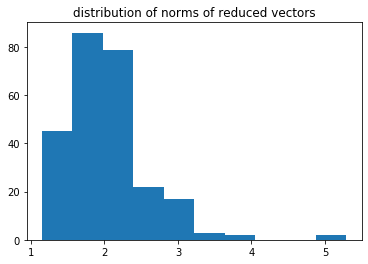

In [15]:
keyword_vectors_reduced = pca.transform(keyword_vectors)
plt.title('distribution of norms of reduced vectors')
plt.hist([np.linalg.norm(vector) for vector in keyword_vectors_reduced])
plt.show()

In [16]:
selected['vector'] = [np.array2string(vector)[1:-1] for vector in keyword_vectors_reduced] # convert so that csv is parsed nicely
selected.head()

,title,keywords,vector
id,,,
11,Star Wars,android galaxy hermit death star lightsaber je...,5.69282148e-01 -8.72842700e-01 -5.00661518e-0...
12,Finding Nemo,father son relationship harbor underwater fish...,-8.32615684e-01 -9.98959202e-02 3.65782679e-0...
13,Forrest Gump,vietnam veteran hippie mentally disabled runni...,-7.65177915e-01 7.78460857e-02 7.39511053e-0...
14,American Beauty,male nudity female nudity adultery parent chil...,-5.70451839e-01 7.45468314e-01 1.77388754e-0...
18,The Fifth Element,clone taxi cyborg egypt future stowaway space ...,-3.05097483e-01 -3.74847818e-01 -9.37452858e-0...


In [17]:
selected.to_csv('processed.csv', index=False)